# IMR-575 targetted analysis

### Module and data import

In [45]:
import pydeseq2
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import scipy.stats as stats
import math
import os

import Tim_diffex_tools as tim 

In [46]:
imr_fpkm = pd.read_csv("IMR575_fpkm.csv").set_index("gene_id")
# Reformatting names (ignore)
reformatted = {col:tim.cleanname(col) for col in imr_fpkm.columns if "DOX" in col}
reformatted

{'DOXn_DPIn_1': 'Control',
 'DOXn_DPIn_2': 'Control',
 'DOXn_DPIn_3': 'Control',
 'DOXn_DPIp_1': 'DOX-DPI+',
 'DOXn_DPIp_2': 'DOX-DPI+',
 'DOXn_DPIp_3': 'DOX-DPI+',
 'DOXp_DPIn_1': 'DOX+DPI-',
 'DOXp_DPIn_2': 'DOX+DPI-',
 'DOXp_DPIn_3': 'DOX+DPI-',
 'DOXp_DPIp_1': 'DOX+DPI+',
 'DOXp_DPIp_2': 'DOX+DPI+',
 'DOXp_DPIp_3': 'DOX+DPI+'}

# 1. Validate DPI knockdown

In [47]:
# Selecting Columns containing sample data and setting the index to gene name
imr_samples = imr_fpkm.set_index("gene_name")[reformatted.keys()]

In [48]:
mycn_data = pd.DataFrame(imr_samples.loc["MYCN"])

# Create a treatment column
mycn_data["Treatment"] = [reformatted[sample] for sample in mycn_data.index]

# As we are interested in the % knockdown, we take the average of the control
mean_mycn = mycn_data["MYCN"][mycn_data["Treatment"]=="Control"].mean()
mycn_data["% of Control"] = (mycn_data["MYCN"]/mean_mycn)*100

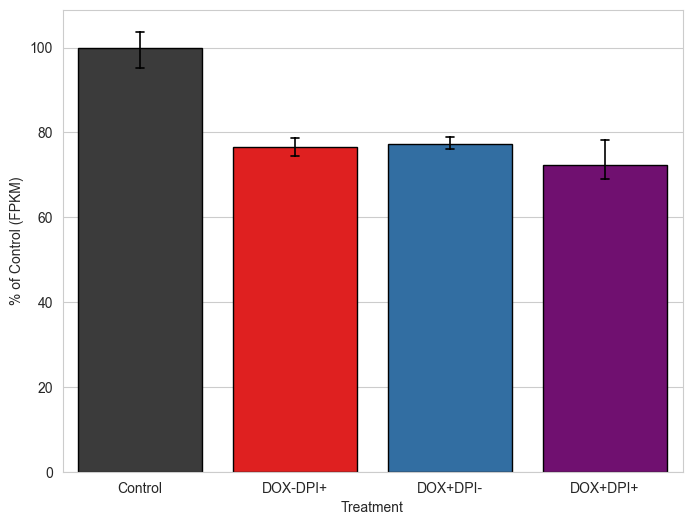

In [49]:
plt.figure(figsize=(8,6))

sns.barplot(
    data=mycn_data,
    x="Treatment",
    y="% of Control",
    capsize=0.05,
    palette=["#3b3b3b","red","#2070b4","purple"],          
    err_kws={
        "color": "black",    
        "linewidth": 1.2, 
    },
    edgecolor="black"
)
plt.ylabel("% of Control (FPKM)")
plt.show()

# 2. Compare to the Liu et al. study 

In [50]:
liu_genes = pd.read_excel(r"C:\Users\Tim\OneDrive\__ThesisProject\_Papers\Liu_K9K14_2023\K9ac_regulated_genes_in_GBM.xlsx")
liu_genes["Genes_list"] = liu_genes["Genes"].apply(lambda x: x.split(","))
liu_genes["len_geneslist"] = liu_genes["Genes_list"].apply(len)
liu_genes.set_index("Mark",inplace=True)

In [51]:
k9ac = liu_genes["Genes_list"].loc["K9ac_regulated_genes_in_GBM"]
k14ac = liu_genes["Genes_list"].loc["K14ac_regulated_genes_in_GBM"]

### **K9ac**

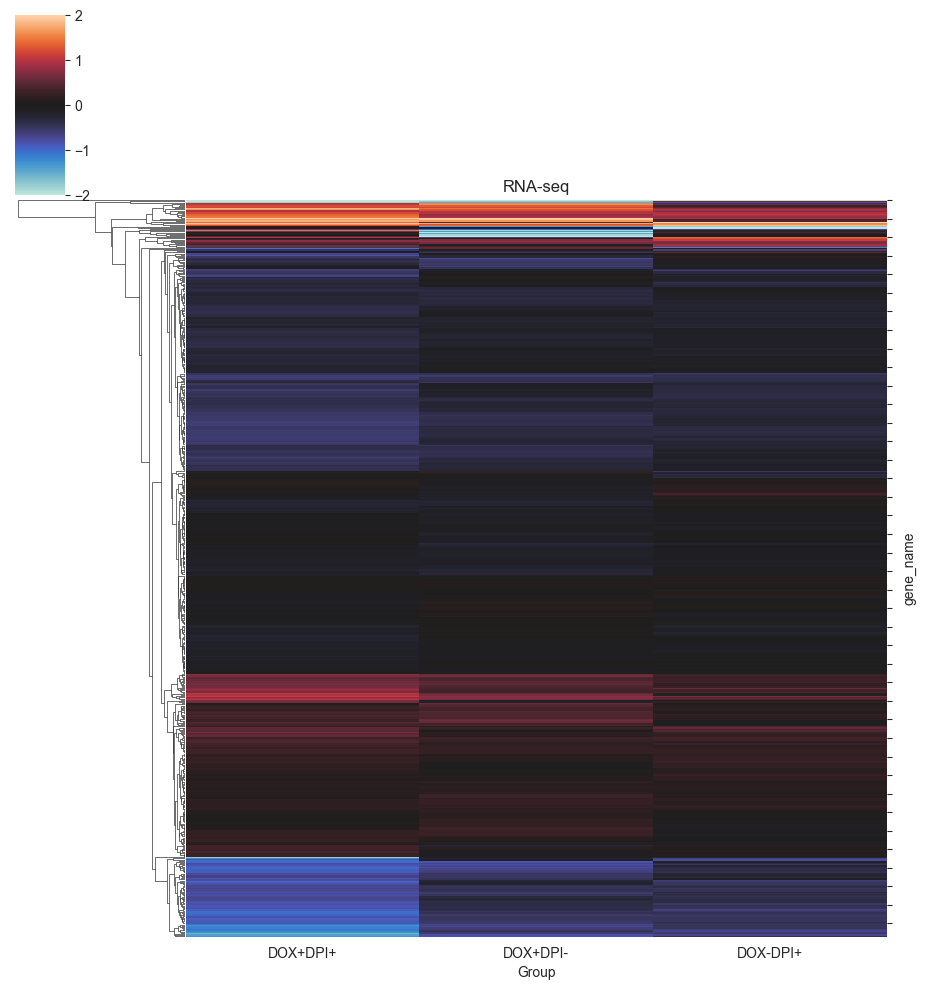

In [52]:
# Filter for only genes in the list
genes = list(set(imr_samples.index) & set(k9ac))
#genes = list(imr_samples.sample(600).index)

k9_data =  imr_samples.loc[genes]

# Filter out genes which were not detected at all
k9_data =k9_data[k9_data.sum(axis=1) !=0]


# Group the data 
k9_data = k9_data.T
k9_data["Group"] = [reformatted[sample] for sample in k9_data.index]

# Calculate means 
vk9_groups = k9_data.groupby("Group").mean().T

# Calculate fold-change to control
group_fc = vk9_groups.div(
    vk9_groups["Control"],
    axis=0
)
# ====================================== # 

data= group_fc.iloc[:,1:].apply(np.log2).replace(np.inf,0).replace(np.nan,0).replace(-np.inf,0)

data = data[data.sum(axis=1)!=0]

g = sns.clustermap(
    data=data,
    metric="euclidean",
    cmap="icefire",
    col_cluster=False,
    center=0,
    vmin=-2, 
    vmax=2,
    #figsize=(10, len(data)/3)
)

g.ax_heatmap.set_yticklabels([])

g.ax_heatmap.set_title("RNA-seq")
plt.show()


### repeat the analysis but with z-score

In [53]:
imr_zscored=imr_samples.T.apply(stats.zscore,axis=0)

### **K14ac**

In [54]:
k9ac_genes_present = list(set(imr_samples.index) & set(k14ac))

k9ac_zscore = imr_zscored[k9ac_genes_present].T
k9ac_zscore=k9ac_zscore[~np.isnan(k9ac_zscore["DOXn_DPIn_1"])]

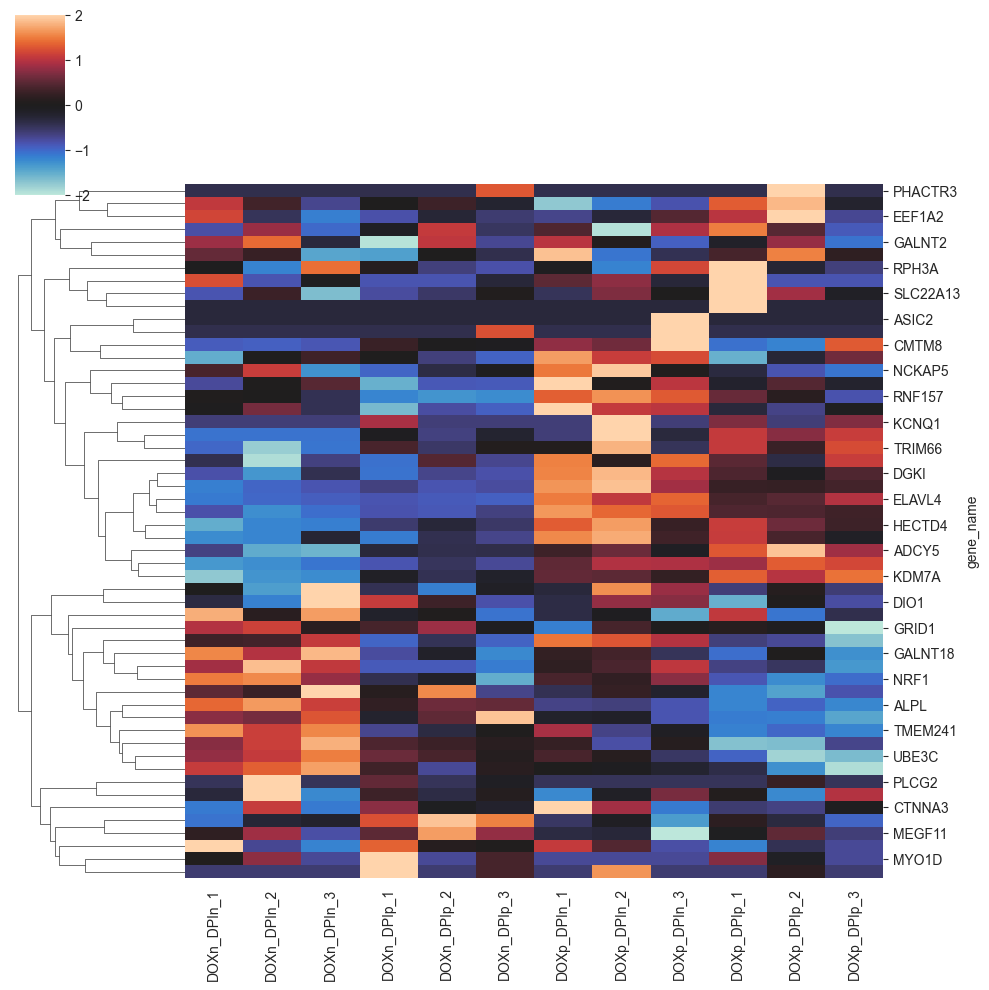

In [55]:
sns.clustermap(
    k9ac_zscore,
    center=0,
    cmap="icefire",
    vmin=-2,vmax=2,
    metric="euclidean",
    col_cluster=False,
)

# 3. Check Acetylation genes

In [57]:
genesetlist = os.listdir(r"C:\Users\Tim\OneDrive\__ThesisProject\_DryLab\IMR575_RNA-seq\Gene_sets")
geneset_paths = [fr"C:\Users\Tim\OneDrive\__ThesisProject\_DryLab\IMR575_RNA-seq\Gene_sets\{gene_set}" for gene_set in genesetlist]

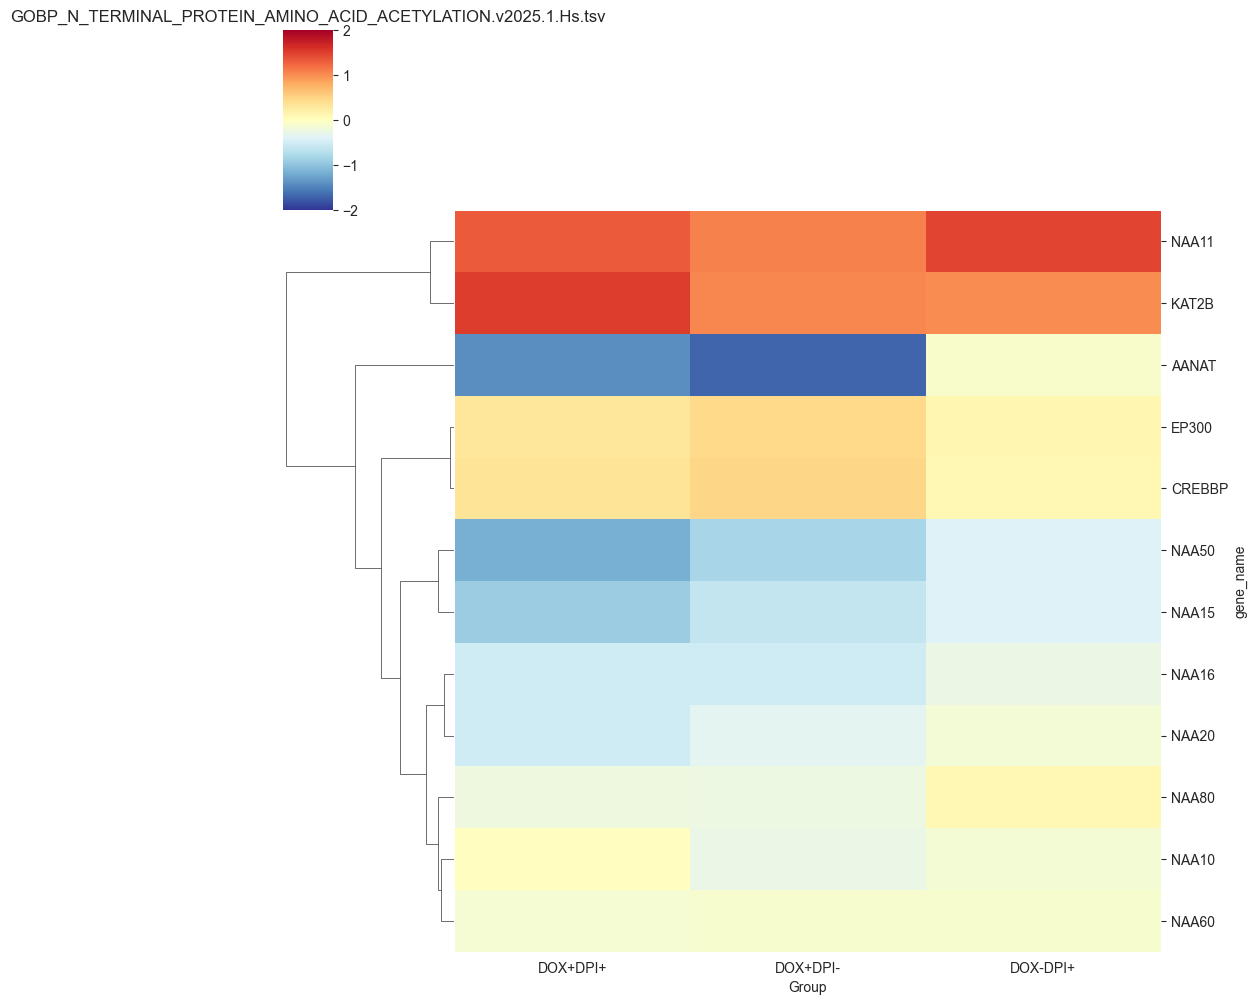

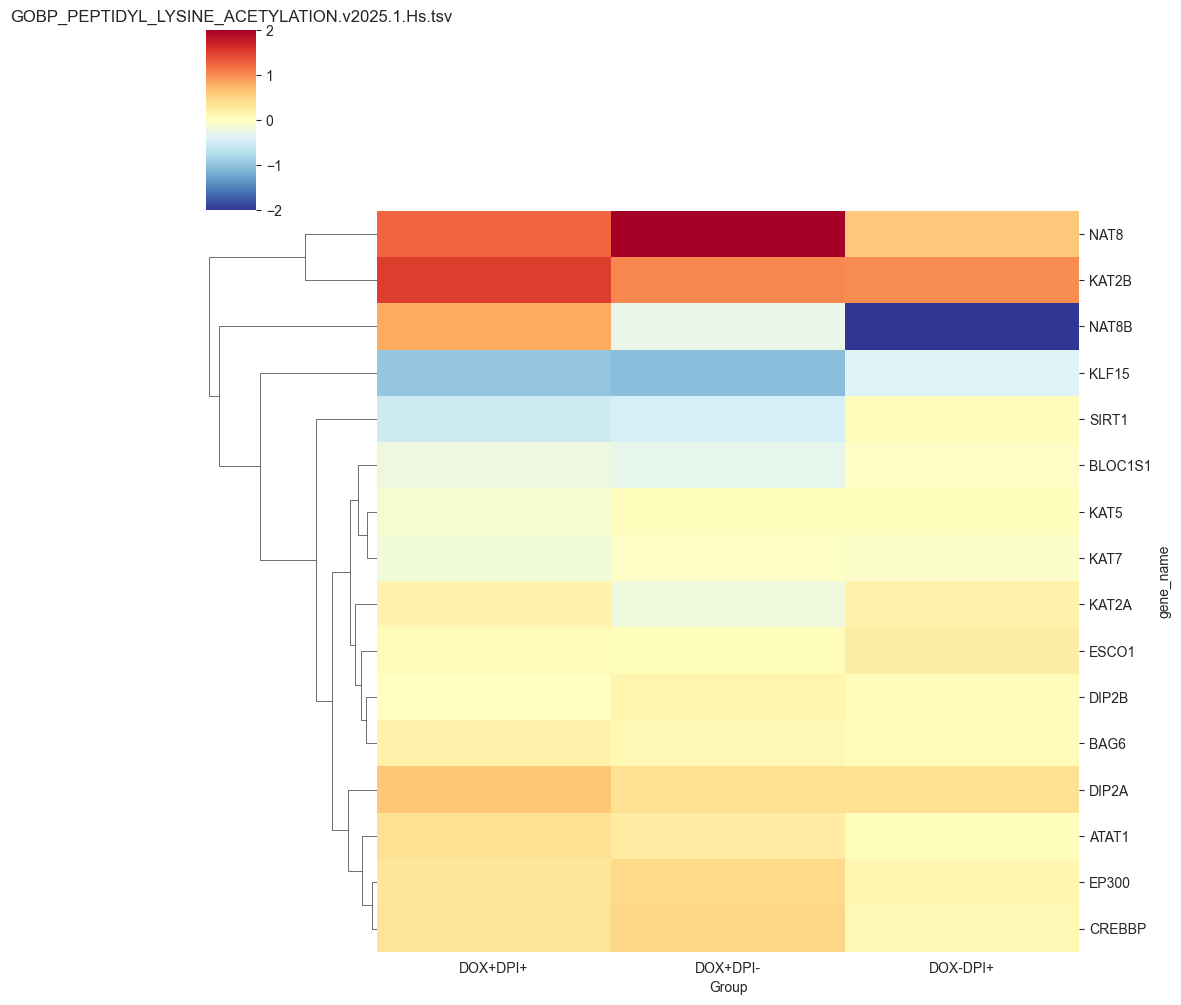

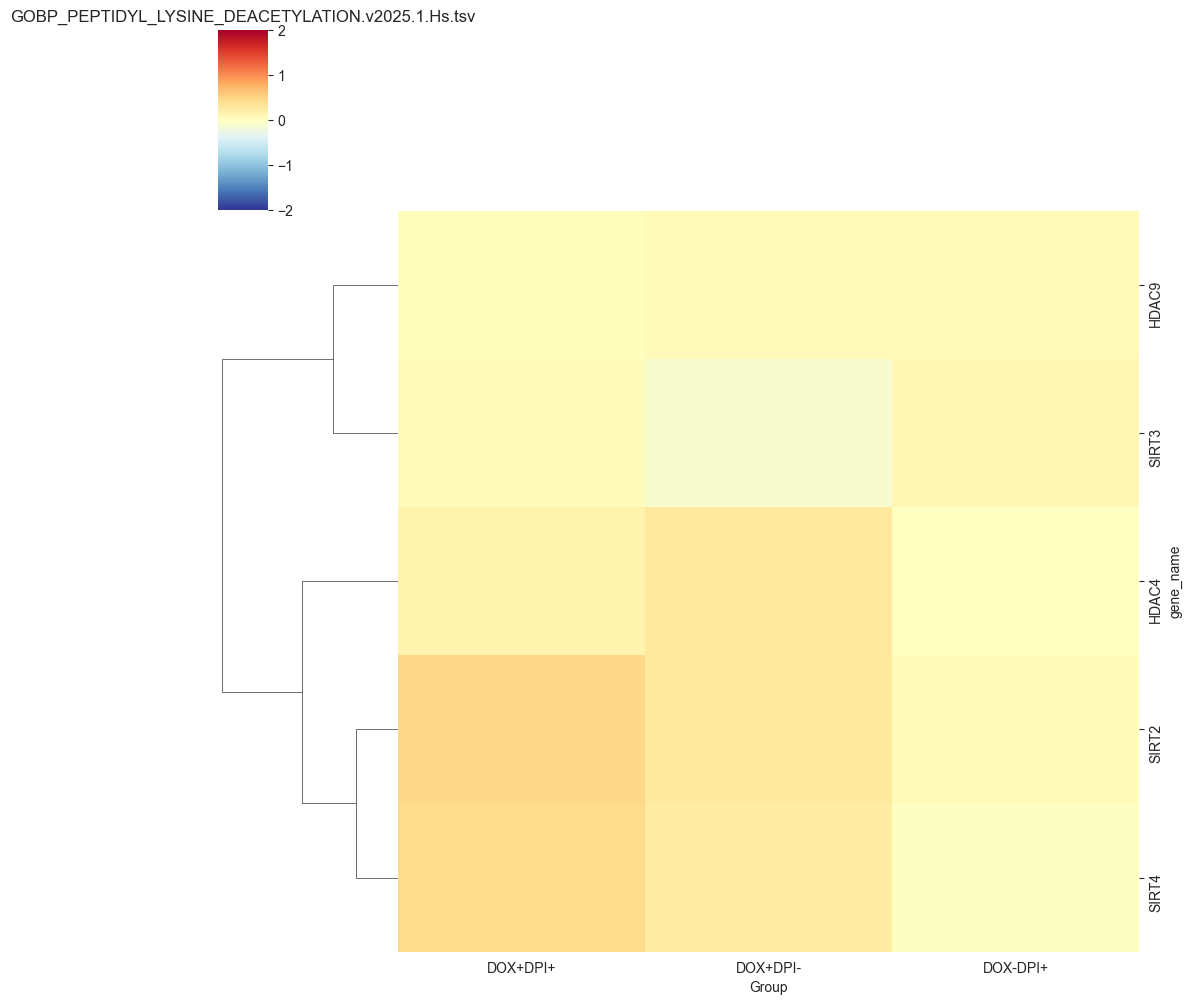

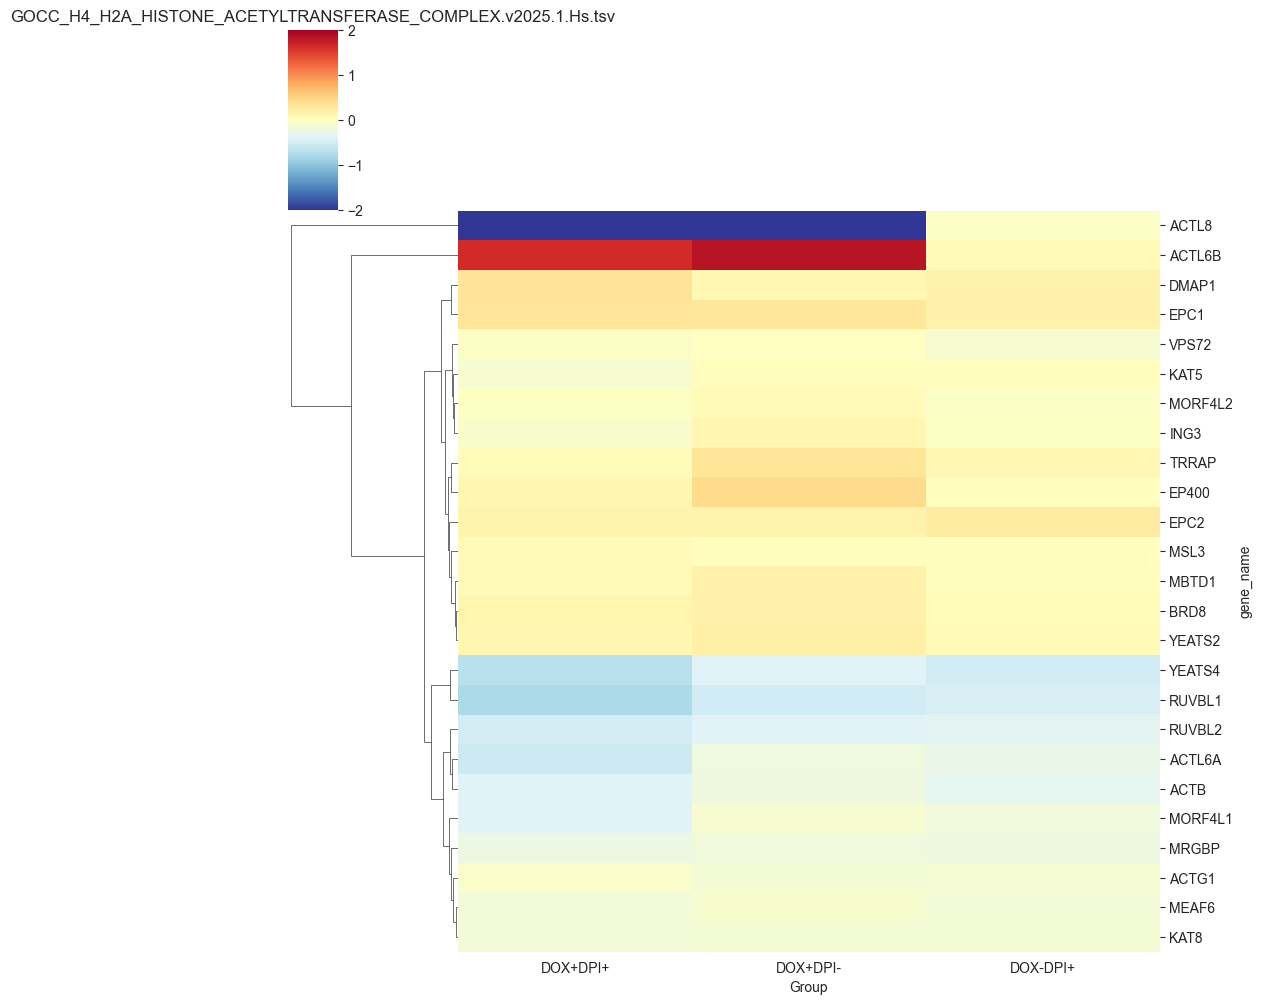

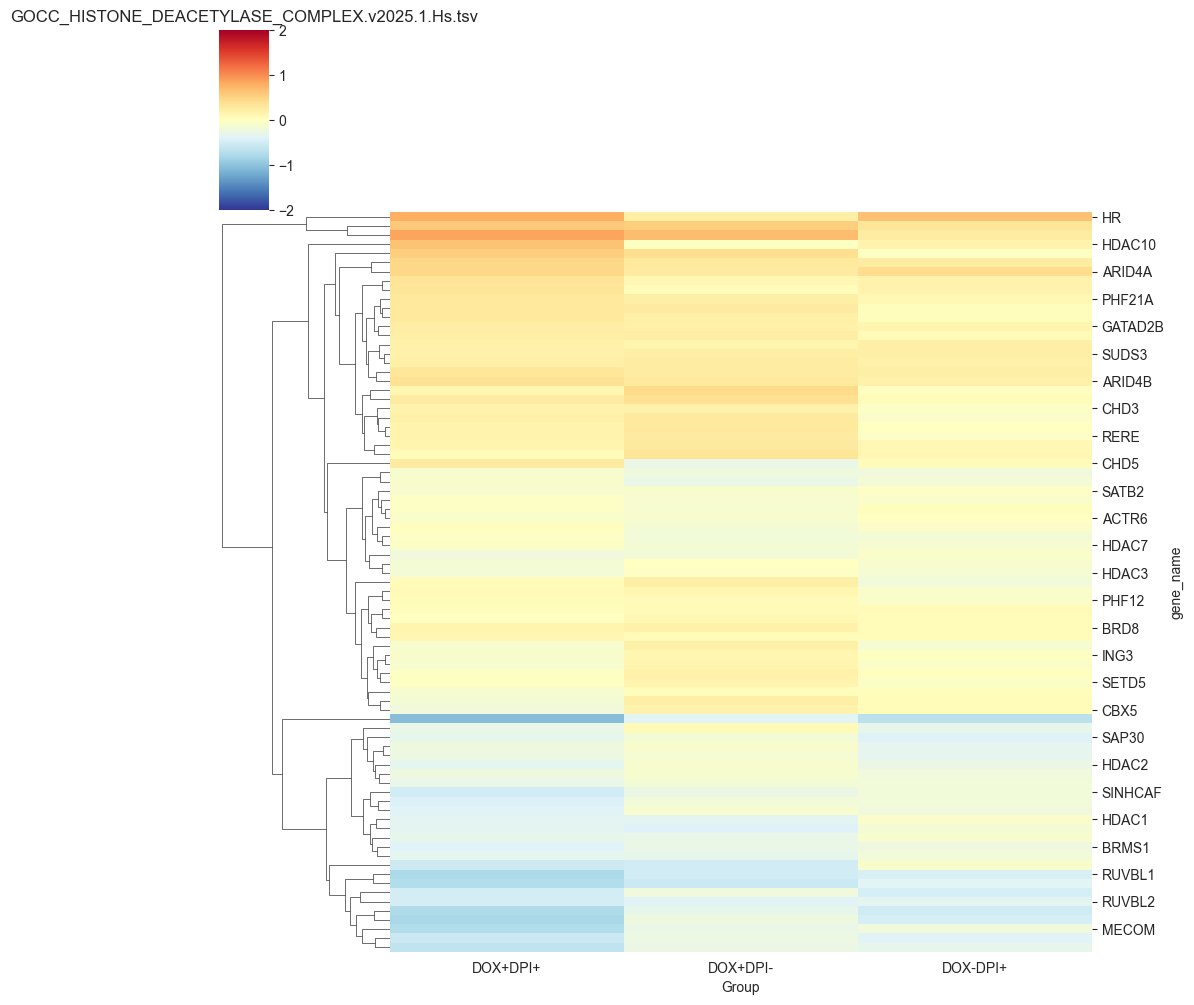

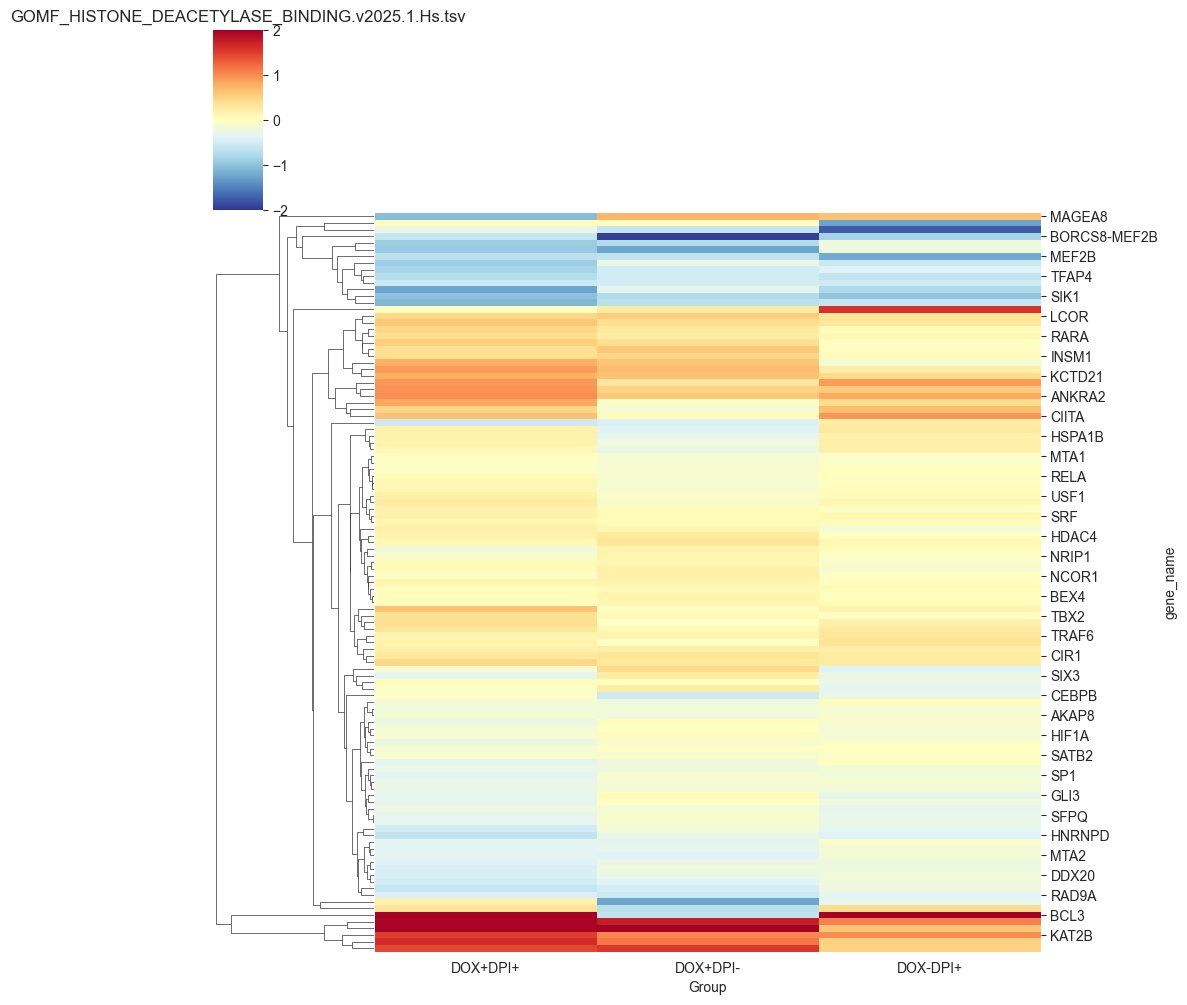

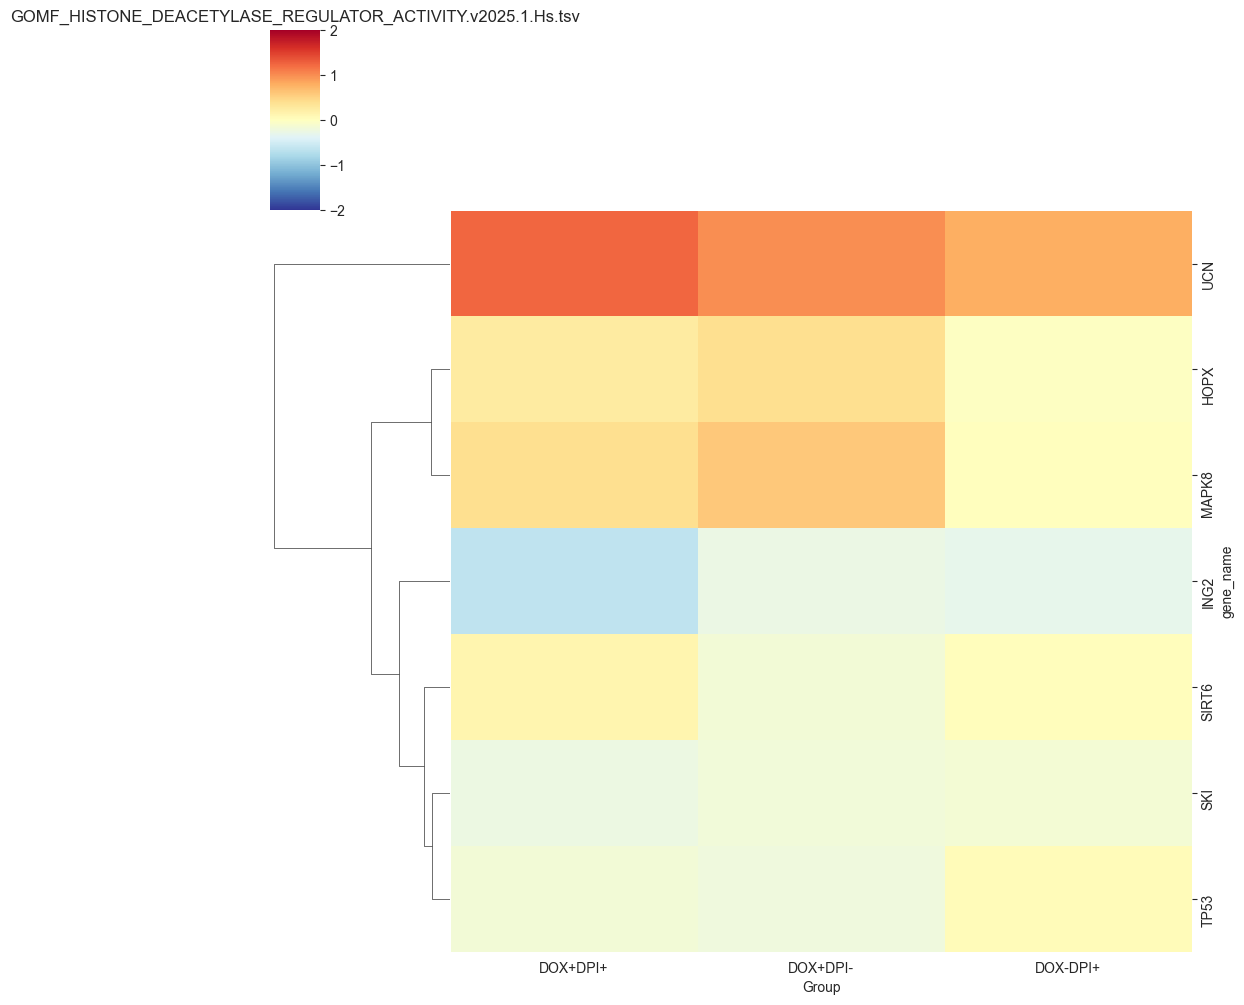

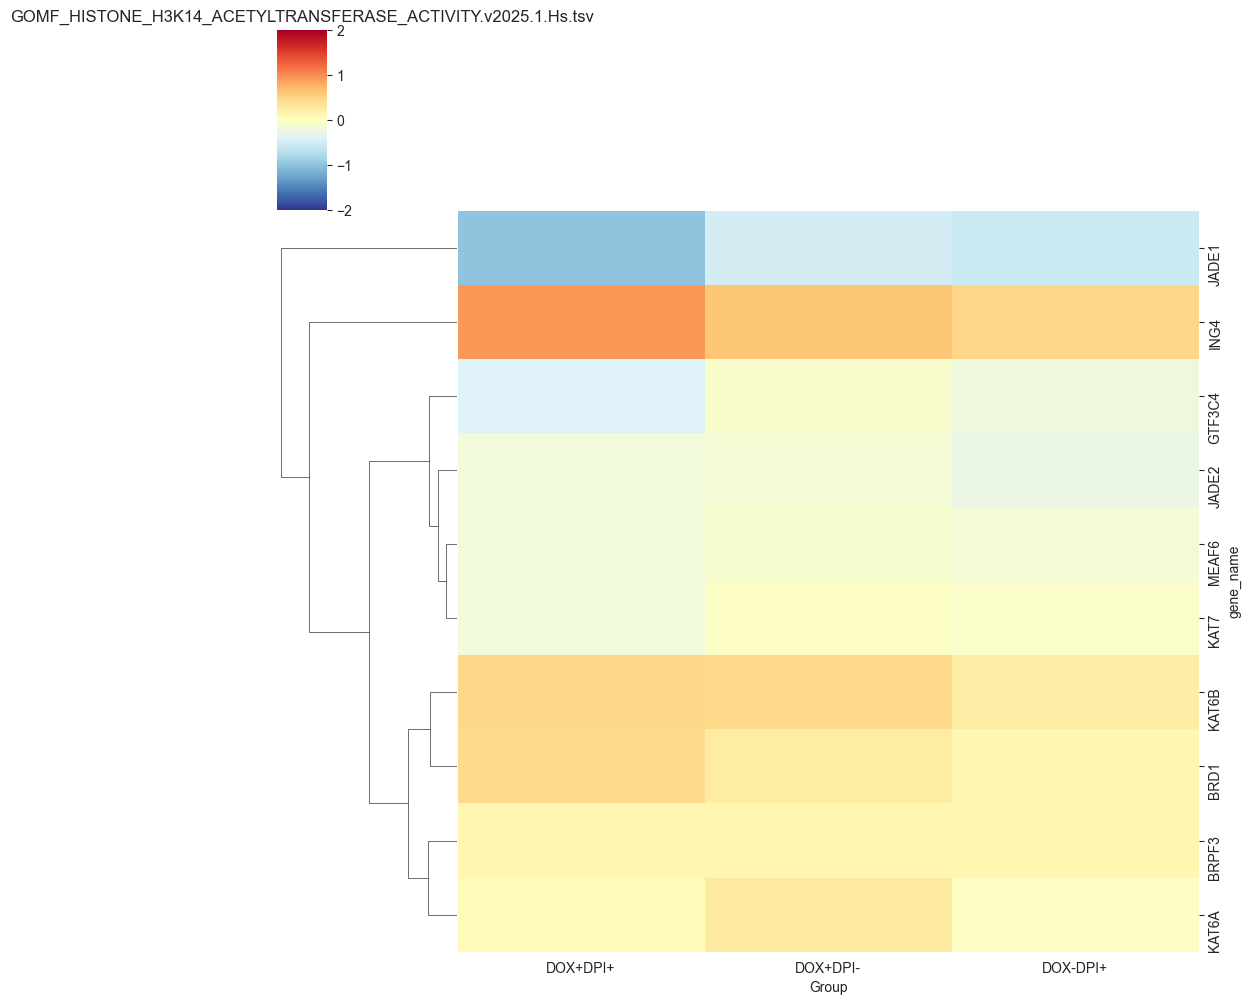

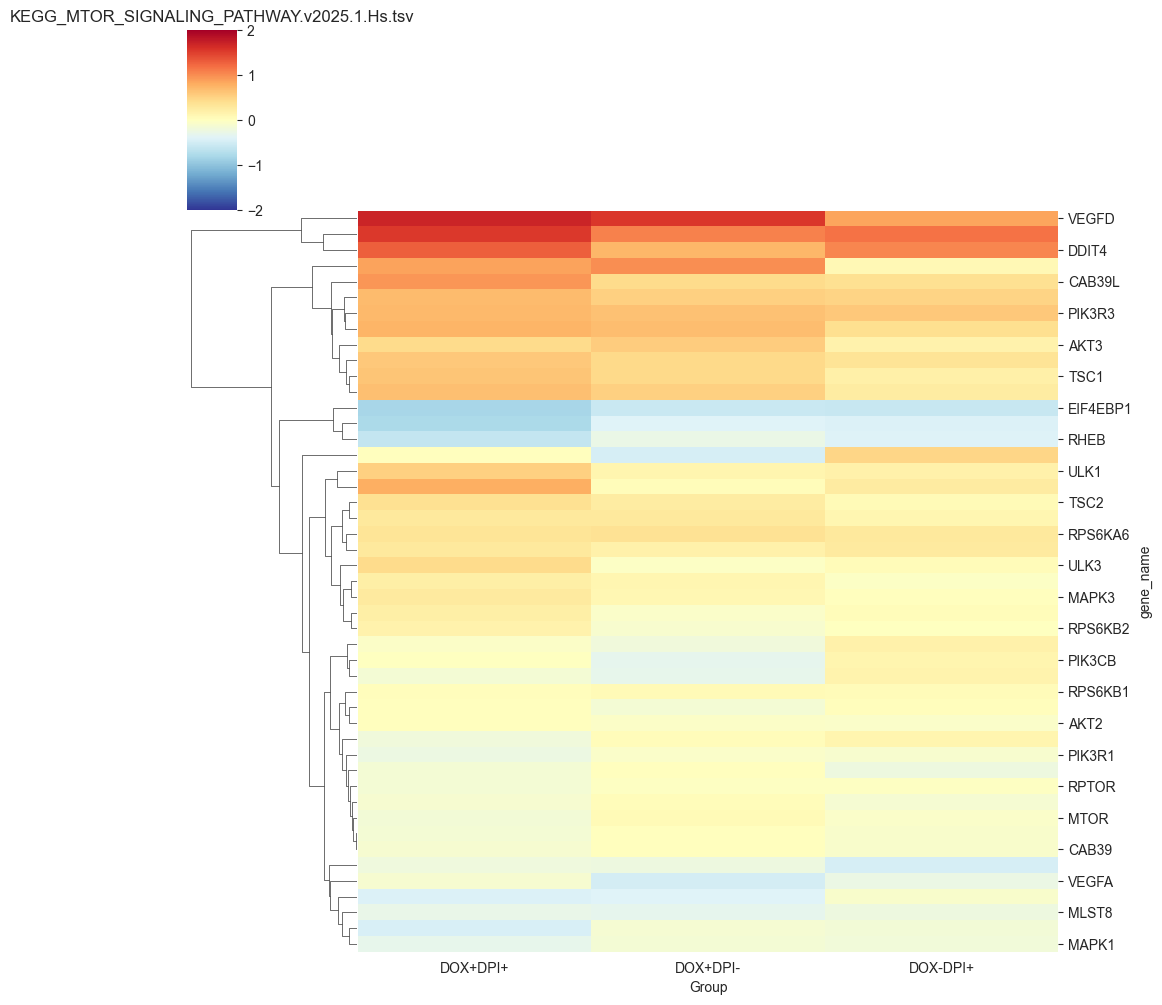

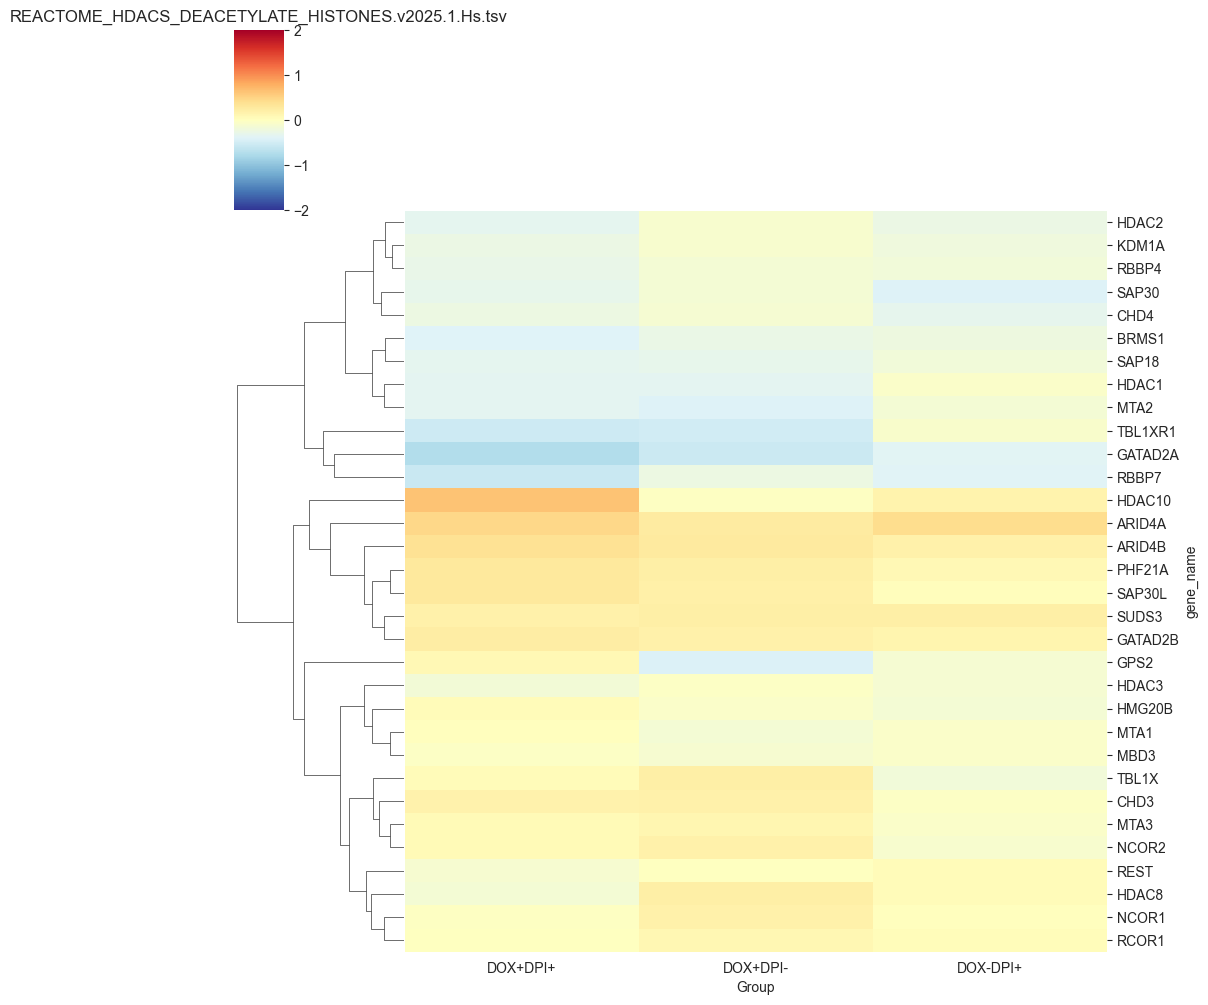

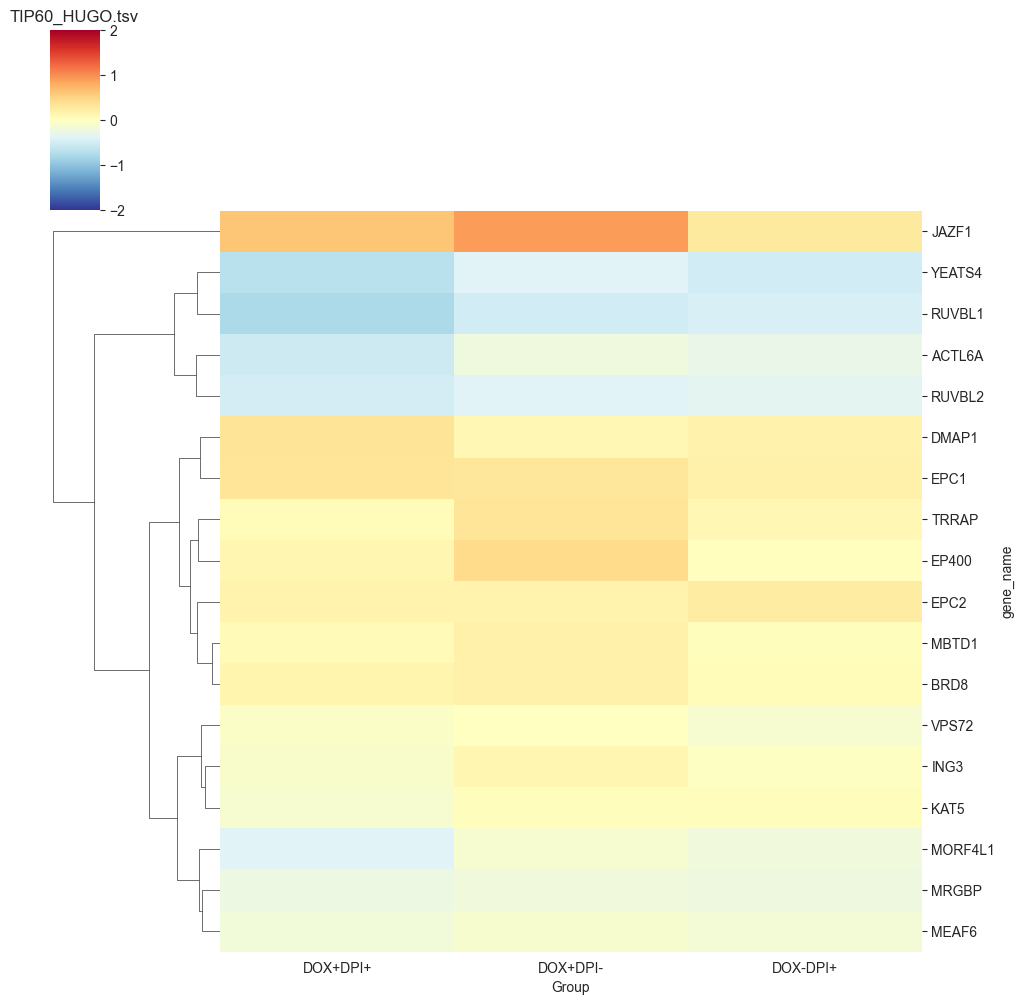

In [58]:
genesetlist = os.listdir(r"C:\Users\Tim\OneDrive\__ThesisProject\_DryLab\IMR575_RNA-seq\Gene_sets")

for gene_set in genesetlist:
    acetyl_genes = pd.read_csv(fr"C:\Users\Tim\OneDrive\__ThesisProject\_DryLab\IMR575_RNA-seq\Gene_sets\{gene_set}",delimiter="\t").set_index("STANDARD_NAME").loc["GENE_SYMBOLS"].values
    acetyl_genes = acetyl_genes[0].split(",")

    # Filter for only genes in the list
    genes = list(set(imr_samples.index) & set(acetyl_genes))
    #genes = list(imr_samples.sample(600).index)

    k9_data =  imr_samples.loc[genes]

    # Filter out genes which were not detected at all
    k9_data =k9_data[k9_data.sum(axis=1) !=0]


    # Group the data 
    k9_data = k9_data.T
    k9_data["Group"] = [reformatted[sample] for sample in k9_data.index]

    # Calculate means 
    vk9_groups = k9_data.groupby("Group").mean().T

    # Calculate fold-change to control
    group_fc = vk9_groups.div(
        vk9_groups["Control"],
        axis=0
    )


    data= group_fc.iloc[:,1:].apply(np.log2).replace(np.inf,0).replace(np.nan,0).replace(-np.inf,0)

    data = data[data.sum(axis=1)!=0]


    g = sns.clustermap(
        data=data,
        metric="cityblock",
        cmap="RdYlBu_r",
        col_cluster=False,
        center=0,
        vmin=-2, 
        vmax=2,
        #figsize=(10, len(data)/3)
    )
    plt.title(gene_set)
